In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils

from VQVAE import VQVAE
from train import train
from utilities import start_mlflow_experiment, Params, save_to_mlflow, count_parameters, load_full_state, select_gpu

from tqdm import tqdm
import mlflow

In [2]:
import os
for root, dirs, files in os.walk('/share/lazy/will/ConstrastiveLoss/test/'):
    for file in files:
        if file.endswith('.png'):
            print(os.path.join(root, file))


/share/lazy/will/ConstrastiveLoss/test/mask.png
/share/lazy/will/ConstrastiveLoss/test/img.png


In [3]:
# math stuff for initial perspective transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from pyquaternion import Quaternion

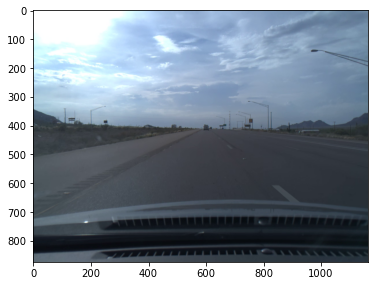

In [211]:
im = np.asarray(Image.open('/share/lazy/will/ConstrastiveLoss/test/img.png'))
plt.imshow(im)
plt.show()

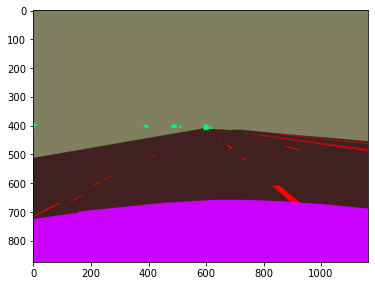

In [4]:
plt.rcParams["figure.figsize"] = (6,6)
im = np.asarray(Image.open('/share/lazy/will/ConstrastiveLoss/test/mask.png'))
plt.imshow(im)
plt.show()

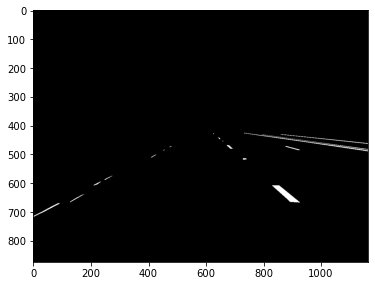

In [5]:
lane_lines = im[:, :, 0] == 255

plt.imshow(255*np.dstack((lane_lines, lane_lines, lane_lines)))
plt.show()

In [6]:
# x, y coordinates of lane lines in 2d space
points = np.argwhere(lane_lines).T

In [ ]:
# constructing the horizon line manually by inspection
y = np.linspace(394, 425, 1000)
x = np.linspace(0, 1200, 1000)

# this bit adds the line to the plot
im = np.asarray(Image.open('/share/lazy/will/ConstrastiveLoss/test/img.png')).copy()
points = list(zip(y, x.round(0)))
for y, x in points:
    im[int(y):int(y+2), int(x):int(x)+2] = [255, 255, 0]

In [7]:
# image height / 2, aka principle point in y direction
Py = im.shape[0]//2

In [8]:
# need to re-define y since calling zip() screws it up 
y = np.linspace(394, 425, 1000)

# image height / 2, aka principle point in y direction
Py = im.shape[0]//2

# get vanishing point (approximately) in y direction
vp_y = y[len(y)//2].round(0)

# use the above information to get pitch angle
focal_length = 910.0
pitch = math.atan((Py - vp_y)/focal_length)

In [9]:
# horizon line
y = np.linspace(394, 425, 1000)
x = np.linspace(0, 1200, 1000)

# use angle of horizon line as roll angle
delta_y = y[-1] - y[0]
delta_x = x[-1] - x[0]
roll = math.atan(delta_y/delta_x)

In [ ]:
# ==================== EXTRINSIC MATRIX ASSEMBLY ====================
new_rot_matrix = np.matmul(calibration_rotation_matrix, BEV_homography_matrix)
transform_matrix = np.eye(4)
transform_matrix[:3, :3] = new_rot_matrix

# chozen transform in Z direction, can make it large and maybe make sure you did it right? idk
# transform_matrix[2, 3] = 1

In [188]:
# BEV transform array
BEV_homography_matrix = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
])

In [11]:
# ==================== INTRINSIC MATRIX ====================

# this is specific to EON, we can use this here because the data came from comma 10k with known intrinsics
camera_intrinsics = np.eye(3)
camera_intrinsics[0,0] = focal_length
camera_intrinsics[1,1] = focal_length
# horizontal midpoint
camera_intrinsics[0, 2] = im.shape[1]//2
# vertical midpoint
camera_intrinsics[1, 2] = im.shape[0]//2


In [12]:
# do operations in homogeneous coordinates
homo_points = np.vstack((points, np.ones((1, points.shape[1])) ))

# apply the inverse of the intrinsic matrix. 3d matrix so our conversion to 3d homogeneous coordinates is enough
# if we had translation we would require an additional dimension, since transformer matrix is 3x4.
cam_p_points = np.dot(np.linalg.inv(camera_intrinsics), homo_points)


In [119]:
# import cv2
# calibration_rotation_matrix = Quaternion([1, 0, -0.0001, 0]).rotation_matrix
# image = np.asarray(Image.open('/share/lazy/will/ConstrastiveLoss/test/img.png'))
# warped = cv2.warpPerspective(src=image, M=new_rot_matrix, dsize=image.shape[0:2])
# plt.imshow(image)
# plt.show()
# plt.imshow(warped)
# plt.show()

In [397]:
# ==================== EXTRINSIC MATRIX ASSEMBLY ====================
# maybe = np.linalg.inv(BEV_homography_matrix)
calibration_rotation_matrix = Quaternion([1, 0, pitch, roll]).rotation_matrix
BEV_homography_matrix = Quaternion([1, 0, -0.75, 0]).rotation_matrix

new_rot_matrix = np.matmul(BEV_homography_matrix,calibration_rotation_matrix)
transform_matrix = np.eye(4)
transform_matrix[:3, :3] = new_rot_matrix

bev_points = np.vstack((cam_p_points, np.ones((1, cam_p_points.shape[1])) ))
hmm = np.dot(transform_matrix, bev_points)
hmm = hmm/hmm[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 144x144 with 0 Axes>

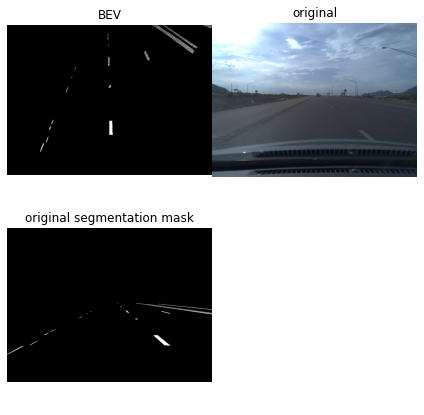

In [398]:
plt.rcParams["figure.figsize"] = (6,6)
test = 1000*(hmm[0:2] - hmm[0:2].min())/(hmm[0:2].max() - hmm[0:2].min())
empty = np.zeros( (int(test[0].max().round(0)+100), int(test[1].max().round(0))+100) )
for x, y in test[0:2].T:
    empty[int(x), int(y)] = 1


import matplotlib.gridspec as gridspec

plt.figure(figsize = (2,2))
gs1 = gridspec.GridSpec(2, 2)
gs1.update(wspace=0.025, hspace=0.05)


fig, ax = plt.subplots(2, 2, tight_layout=True, gridspec_kw = {'wspace':0, 'hspace':0})
ax[0,0].imshow(255*np.dstack((empty, empty, empty))[50:490, 400:999]) #[50:490, 400:999]
ax[0,0].set_title('BEV')
ax[1,0].imshow(255*np.dstack((lane_lines, lane_lines, lane_lines)))
ax[1,0].set_title('original segmentation mask')
ax[0,1].imshow(im)
ax[0,1].set_title('original')

ax[0,0].set_axis_off()
ax[1,0].set_axis_off()
ax[0,1].set_axis_off()
ax[1,1].set_axis_off()
fig.show()

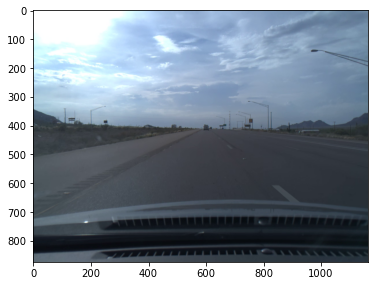

In [336]:
plt.imshow(im)
plt.show()

In [ ]:
f = open("/share/lazy/will/ConstrastiveLoss/Imgs/color_images/vanishing_points/VP dataset/highway/10691/10691_468.txt", "r")
print(f.read())

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, target_paths):
        self.image_paths = image_paths
        self.target_paths = target_paths

    def transform(self, image, mask):

        # Resize image
        resize_img = torchvision.transforms.Resize(new_size)
        image = resize_img(image)

        # Convert mask to binary image and extract only the channel we need
        mask = np.asarray(mask).astype(np.int32)
        image = np.asarray(image).astype(np.int32).transpose(2, 0, 1)
        mask = np.array(mask[:,:,0]) == 255

        # Resize                                           ### NEEDS FIX ===========
        mask = resize(255*mask, new_size)
        mask = (mask > np.min(mask)*100).reshape(1, *mask.shape)

        return image, mask

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
        return x, y

    def __len__(self):
        return len(self.target_paths)

In [ ]:
args = Params(16, 10, 4e-4, 256, 'cuda:1')

start_mlflow_experiment('VP net', 'lane-finder')


transform = transforms.Compose([
        transforms.Resize(args.size),
        transforms.CenterCrop(args.size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])

dataset = datasets.ImageFolder('/share/lazy/will/ConstrastiveLoss/Imgs/color_images/vanishing_points/VP dataset/highway/', transform=transform)
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, pin_memory = True)

model = VQVAE(channel=128).to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

run_name = 'delete'
with mlflow.start_run(run_name = run_name) as run:

    for epoch in range(args.epoch):
        results = train(epoch, loader, model, optimizer, args.device)
        for Dict in results:
            print(Dict)
            save_to_mlflow(Dict, args)


In [ ]:
import torch
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import mlflow
from torchvision import transforms


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i*i.sigmoid()
        ctx.save_for_backward(result,i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        result,i = ctx.saved_variables
        sigmoid_x = i.sigmoid()
        return grad_output * (result+sigmoid_x*(1-result))

swish= Swish.apply

class Swish_module(nn.Module):
    def forward(self,x):
        return swish(x)
    
swish_layer = Swish_module()

    

class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            torch.sum(embed_onehot_sum)
            torch.sum(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, kernel_size=3, extra_layers=1, residual=True):
        super().__init__()
        self.residual=residual
        
        layers = [
            nn.Conv2d(in_channel, out_channel, stride=stride, kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.BatchNorm2d(out_channel),
#             nn.ReLU()]
            Swish_module()]
        
        extra_block = [
            nn.Conv2d(out_channel, out_channel, stride=1, kernel_size=3, padding=(3-1)//2),
            nn.BatchNorm2d(out_channel),
#             nn.ReLU()]
            Swish_module()]
        
        for layer in range(extra_layers):
            layers.extend(extra_block)

        self.resblock = nn.Sequential(*layers)

    def forward(self, input):
        if self.residual:
            out = self.resblock(input)
            out = input+out
            return out
        else:
            out = self.resblock(input)
            return out

class Encoder(nn.Module):
    def __init__(self, in_channel, channel, extra_layers, stride, kernel_size, residual, extra_residual_blocks, downsample):
        super().__init__()

        self.out_channels = channel

        blocks = [
            ResBlock(in_channel, channel, extra_layers=extra_layers, stride=stride, residual=residual),
            Swish_module()
#             nn.ReLU(inplace=True)
        ]


        for i in range(extra_residual_blocks):
            blocks.append(ResBlock(in_channel=channel, out_channel=channel, extra_layers=extra_layers, residual=True))
            if (downsample=='Once') & (i==0):
                blocks.append(nn.MaxPool2d(2, 2))
            if (downsample=='Twice') & ((i==0) | (i==1)):
                blocks.append(nn.MaxPool2d(2, 2))
                
        if not extra_residual_blocks:
            blocks.append(nn.MaxPool2d(2,2))

        self.encode = nn.Sequential(*blocks)

    def forward(self, input):
        return self.encode(input)


class Decoder(nn.Module):
    def __init__(self, channel, out_channel, extra_layers, extra_residual_blocks, upsample):
        super().__init__()

        blocks = []

        for i in range(extra_residual_blocks):
            blocks.append(ResBlock(in_channel=channel, out_channel=channel, extra_layers=extra_layers, residual=True))
            if (upsample=='Twice') & (i==0):
                blocks.append(nn.ConvTranspose2d(channel, channel, 4, 2, padding=1))

        blocks.append(nn.ConvTranspose2d(channel, out_channel, 4, 2, padding=1))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    '''
    params: in_channel=3, channel=64, n_res_block=2, n_res_channel=32, embed_dim=64, n_embed=512, decay=0.99
    '''
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=0,
        n_extra_layers=0,
        n_res_channel=32,
        embed_dim=64//2,
        n_embed=512//2,
        decay=0.99
    ):
        '''
        params: in_channel=3, channel=64, n_res_block=2, n_res_channel=32, embed_dim=64, n_embed=512, decay=0.99
        '''
        super().__init__()
        # Encoders, first one should have two rounds of downsampling, second should have one
        self.enc_b = Encoder(in_channel=in_channel, channel=channel, extra_layers=n_extra_layers, stride=2, kernel_size=5, residual=False, extra_residual_blocks=n_res_block, downsample='Once')
        self.enc_t = Encoder(in_channel=channel, channel=channel, extra_layers=n_extra_layers, stride=1, kernel_size=3, residual=False, extra_residual_blocks=n_res_block, downsample='Once')

        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)

        # Decoders,
        self.dec_t = Decoder(embed_dim, embed_dim, channel, extra_residual_blocks = n_res_block, upsample='Once')
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        self.dec = Decoder(embed_dim + embed_dim, in_channel, extra_layers=n_extra_layers+1, extra_residual_blocks=n_res_block+1, upsample='Twice')
        
        self.quant_t_conv = nn.Conv2d(32, 2, 3, padding=1)
        self.quant_b_conv = nn.Conv2d(32, 2, 3, padding=1)

        self.transformer_layer_t = nn.Linear(2048, 32)
        self.transformer_layer_b = nn.Linear(8192, 32)

        self.transformer_layer_final = nn.Linear(64, 2)

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        swish = Swish_module()

        x_b = self.quant_b_conv(quant_b)
        x_t = self.quant_t_conv(quant_t)

        x_t = nn.Flatten()(x_t)
        x_b = nn.Flatten()(x_b)

        x_t = self.transformer_layer_t(x_t)
        x_b = self.transformer_layer_b(x_b)

        ret = self.transformer_layer_final(torch.cat([x_b, x_t], 1))
        
        return ret

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)
        print('quant b shape', quant_b.shape)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b
